In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.cluster import KMeans, DBSCAN, OPTICS, SpectralClustering#, HDBSCAN

import prince


# Load Data

In [2]:
filestem = "batch2_20526div21"
filename = 'data/' + filestem + ".data.raw.h5"

In [3]:
Y = mla.load_spikes_from_file(filename, 0, 0, -10)
print(np.shape(Y))

bin_size = 0.02

mode = 'binary'
#mode = 'count'

X = mla.spike_array_from_file(filename, voltage_threshold=-10, mode = mode, bin_size = bin_size)
t = np.arange(0, np.shape(X)[0] * bin_size, bin_size)
print(np.shape(X))

print(X)
# for i, t in enumerate(time_points):
#     for channel in channel_list:
#         if X[i, channel] == 1:
#             plt.scatter(t, channel)

(71240, 3)
num spikes lost: 5814/71240=0.08161145423919147
(30001, 1024)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


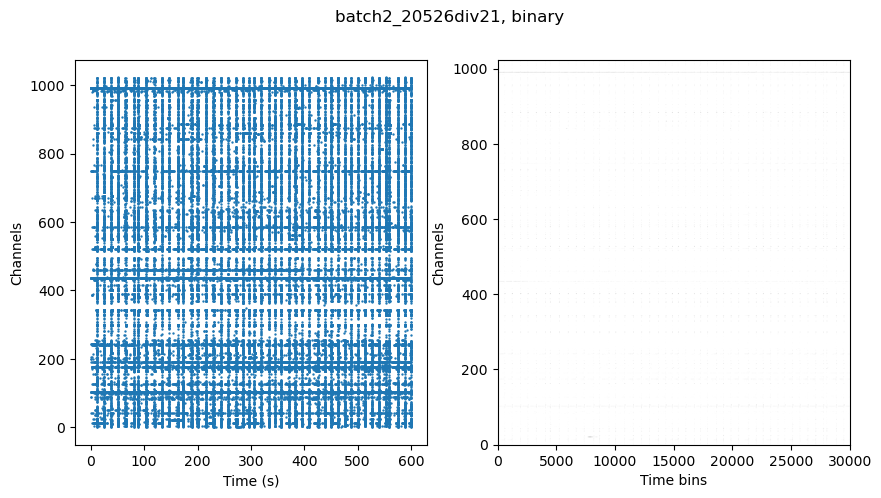

In [154]:


plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y['time'], Y['channel'], 0.5)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Channels')
plt.subplot(1, 2, 2)


plt.imshow(X.transpose() * -1, aspect = 'auto', cmap = 'gray', origin = 'lower')
plt.xlabel('Time bins')
plt.ylabel('Channels')

plt.suptitle(filestem + ', ' + mode)

plt.savefig(filestem + '_' + mode)

# PCA

In [155]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [156]:
n_components = 6

pca = PCA(n_components)
X_pca = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_)

[0.10691227 0.04493578 0.02304416 0.0193283  0.01619796 0.01500433]


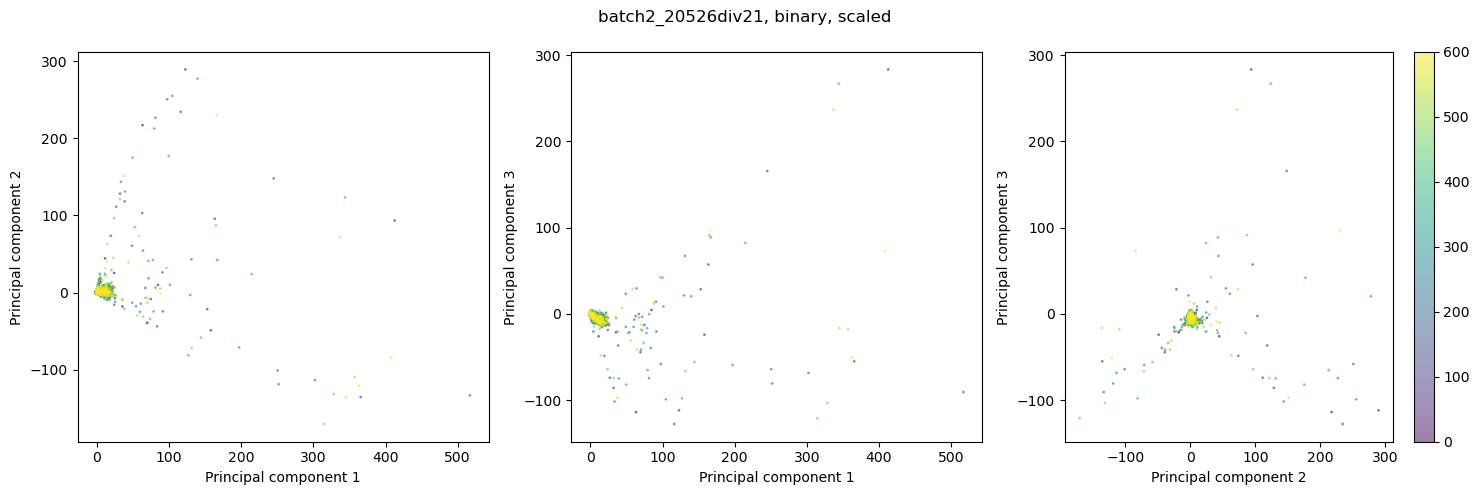

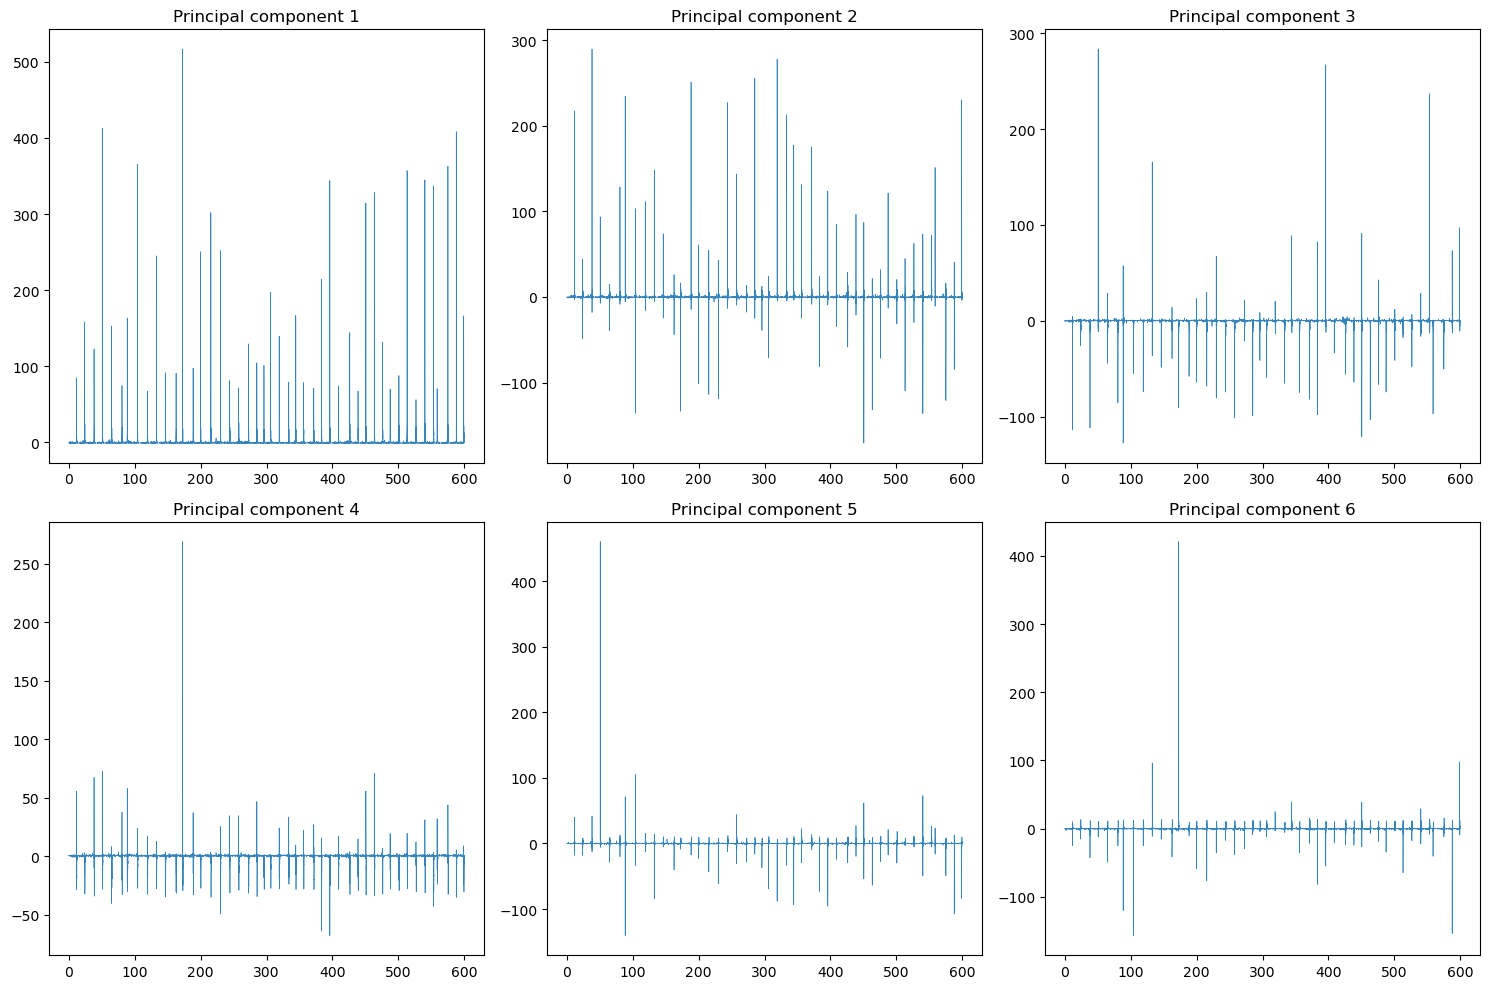

In [157]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')

plt.suptitle(filestem + ', ' + mode + ', scaled')
plt.savefig(filestem + '_' + mode + '_pca_scaled')


plt.tight_layout()

plt.show()

fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_pca[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

# MCA

In [8]:
df = pd.DataFrame(X)
print(df.head())

   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 1024 columns]


In [ ]:
n_components = 2

mca = prince.MCA(n_components, one_hot = False)

X_mca = mca.fit(X)
mca.eigenvalues_summary


# tsne

In [6]:
X_tsne = list()
perplexities = np.arange(500, 3000, 500)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(perplexity = perplexity)
    X_tsne.append(tsne.fit_transform(X_pca))

MemoryError: Unable to allocate 1.34 GiB for an array with shape (180017986,) and data type float64

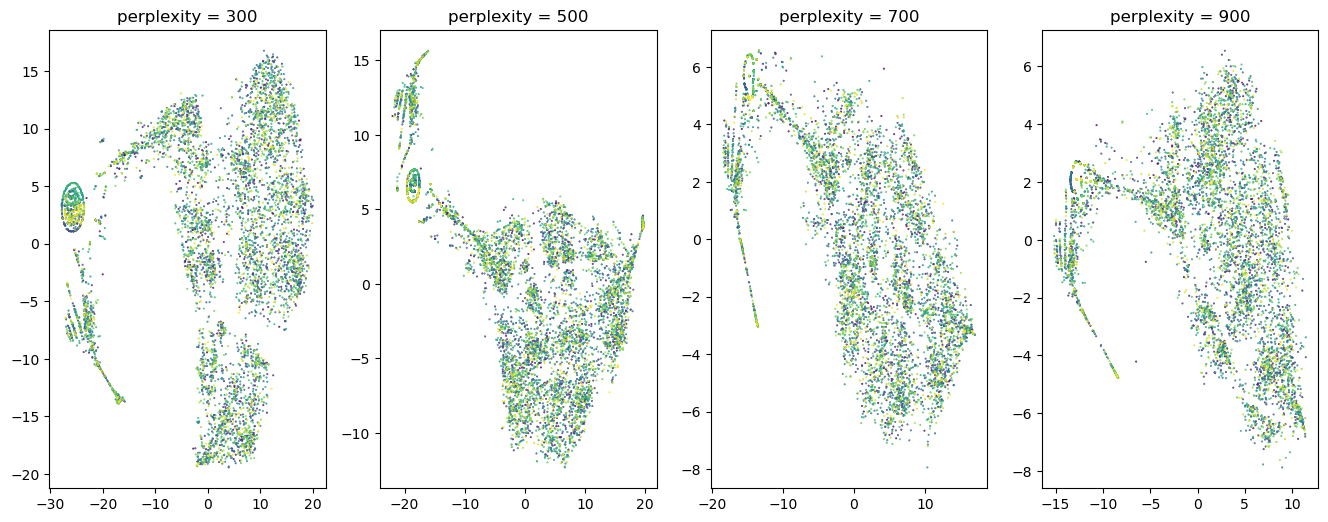

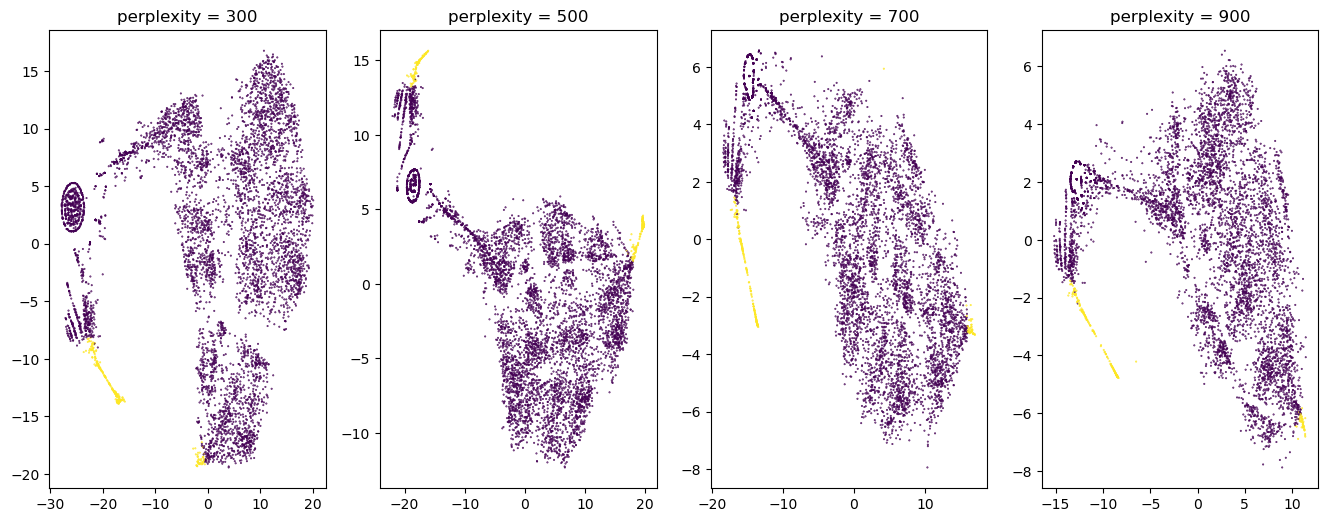

In [ ]:
fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (t))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (X_pca[:, 1] > 2))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()

In [20]:
X_tsne = list()
perplexities = np.arange(1000, 3000, 500)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(perplexity = perplexity)
    X_tsne.append(tsne.fit_transform(X_pca))

KeyboardInterrupt: 

In [1]:
fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (t))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (X_pca[:, 1] > 0))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()

NameError: name 'plt' is not defined

# Isomap

In [18]:
X_isomap = list()
neighbors = np.arange(20, 160, 20)
for i, neighbors in enumerate(neighbors):
    isomap = Isomap(n_neighbors= neighbors)
    X_isomap.append(isomap.fit_transform(X))

MemoryError: Unable to allocate 6.71 GiB for an array with shape (30002, 30002) and data type float64

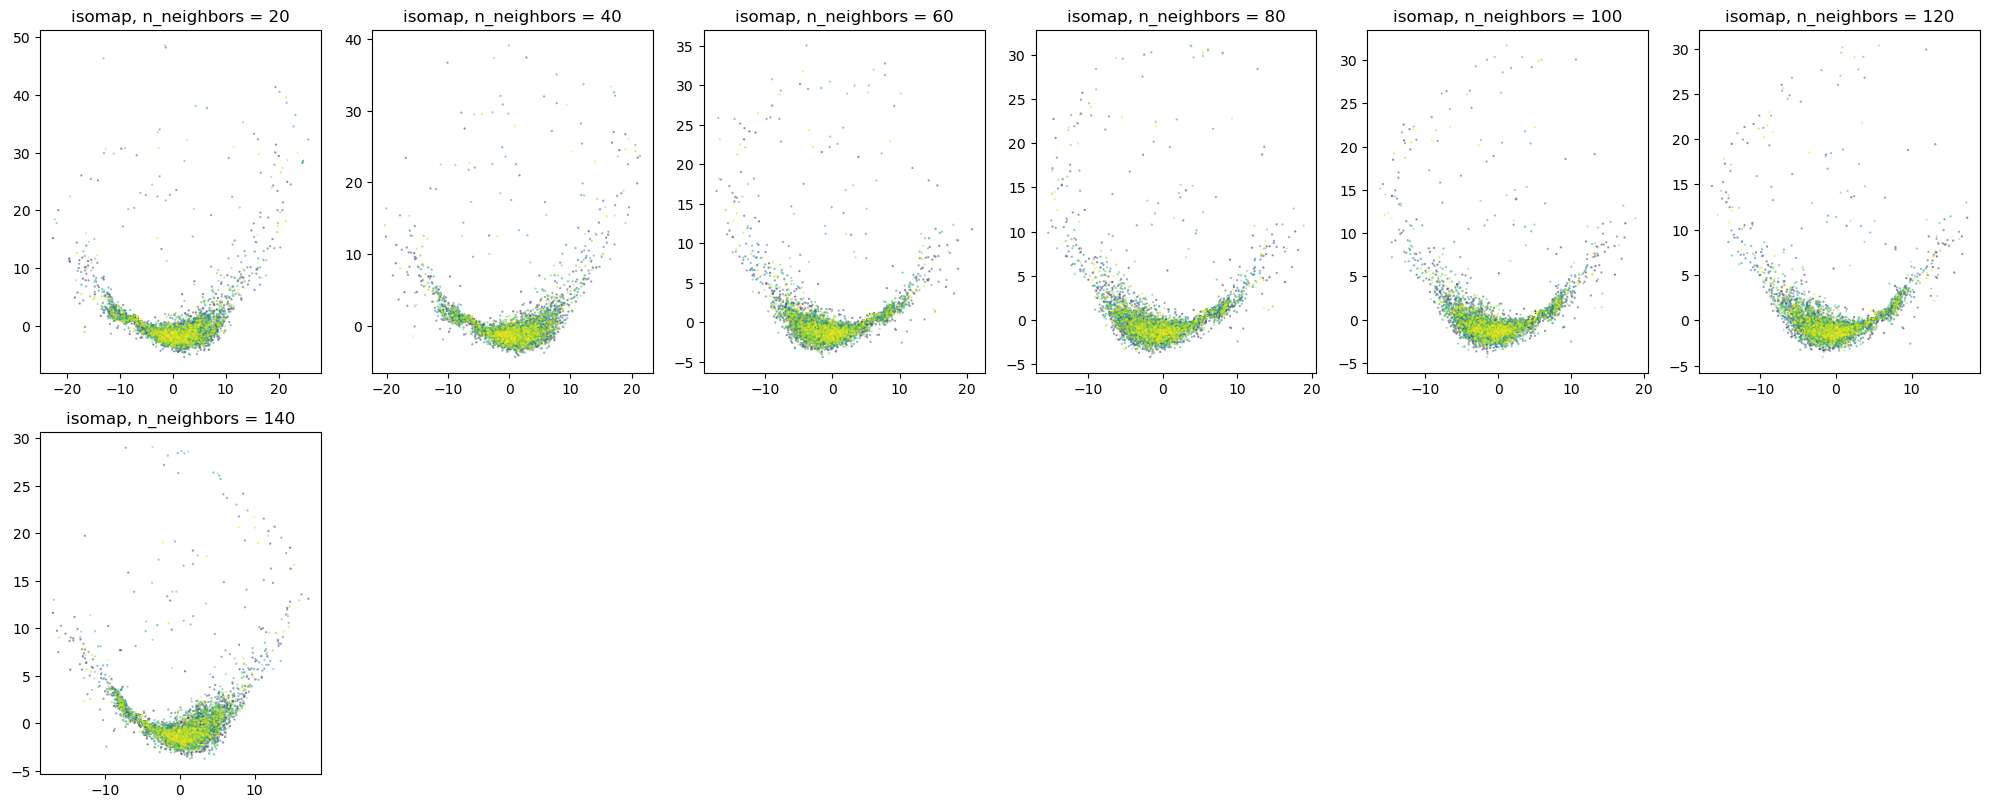

In [9]:
plt.figure(figsize = (20, 20))
for i, neighbors in enumerate(neighbors):
    plt.subplot(5, 6, i+1)
    plt.scatter(X_isomap[i][:, 0], X_isomap[i][:, 1], s = 0.4, alpha=0.5, c = t[:])
    plt.title('isomap, n_neighbors = ' + str(neighbors))

plt.tight_layout()
plt.show()
